In [4]:
# @title Install necessary packages.
# !pip install -U dopamine-rl

In [5]:
import sys
print("Python version")
print (sys.version)

import itertools

Python version
3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [6]:
# @title Necessary imports and globals.

import numpy as np
import os
import pandas as pd
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf
import pickle5 as pickle
import tensorflow as tf
import collections

DQN_BASE_PATH = 'results/DQN_adam'
K = 32
ENSEMBLE_DQN_BASE_PATH = 'results/Ensemble_DQN/replay_scheme=uniform/num_ensemble=10/rew_noise_scale=0.0'
games = ['Pong']
num_iterations = 9

In [7]:
# Note: This code is copied from utils.py. I had to do this because that file used an outdated version of pickle.

def load_baselines(base_dir, verbose=False):
  """Reads in the baseline experimental data from a specified base directory.

  Args:
    base_dir: string, base directory where to read data from.
    verbose: bool, whether to print warning messages.

  Returns:
    A dict containing pandas DataFrames for all available agents and games.
  """
  experimental_data = {}
  for game in GAMES:
    for agent in ['dqn']:
      game_data_file = os.path.join(base_dir, agent, '{}.pkl'.format(game))
      if not tf.io.gfile.exists(game_data_file):
        if verbose:
          # pylint: disable=superfluous-parens
          print('Unable to load data for agent {} on game {}'.format(agent,
                                                                     game))
          # pylint: enable=superfluous-parens
        continue
      with tf.io.gfile.GFile(game_data_file, 'rb') as f:
        if sys.version_info.major >= 3:
          # pylint: disable=unexpected-keyword-arg
          single_agent_data = pickle.load(f, encoding='latin1')
          # pylint: enable=unexpected-keyword-arg
        else:
          single_agent_data = pickle.load(f)
        single_agent_data['agent'] = agent
        # The dataframe rows are all read as 'objects', which causes a
        # ValueError when merging below. We cast the numerics to float64s to
        # avoid this.
        for field_name in single_agent_data.keys():
          try:
            single_agent_data[field_name] = (
                single_agent_data[field_name].astype(np.float64))
          except ValueError:
            # This will catch any non-numerics that cannot be cast to float64.
            continue
        if game in experimental_data:
          experimental_data[game] = experimental_data[game].merge(
              single_agent_data, how='outer')
        else:
          experimental_data[game] = single_agent_data
  return experimental_data

def load_statistics(log_path, iteration_number=None, verbose=True):
  """Reads in a statistics object from log_path.

  Args:
    log_path: string, provides the full path to the training/eval statistics.
    iteration_number: The iteration number of the statistics object we want
      to read. If set to None, load the latest version.
    verbose: Whether to output information about the load procedure.

  Returns:
    data: The requested statistics object.
    iteration: The corresponding iteration number.

  Raises:
    Exception: if data is not present.
  """
  # If no iteration is specified, we'll look for the most recent.
  if iteration_number is None:
    iteration_number = get_latest_iteration(log_path)

  log_file = '%s/%s_%d' % (log_path, FILE_PREFIX, iteration_number)

  if verbose:
    # pylint: disable=superfluous-parens
    print('Reading statistics from: {}'.format(log_file))
    # pylint: enable=superfluous-parens

  with tf.io.gfile.GFile(log_file, 'rb') as f:
    return pickle.load(f), iteration_number


def get_latest_file(path):
  """Return the file named 'path_[0-9]*' with the largest such number.

  Args:
    path: The base path (including directory and base name) to search.

  Returns:
    The latest file (in terms of given numbers).
  """
  try:
    latest_iteration = get_latest_iteration(path)
    return os.path.join(path, '{}_{}'.format(FILE_PREFIX, latest_iteration))
  except ValueError:
    return None


def get_latest_iteration(path):
  """Return the largest iteration number corresponding to the given path.

  Args:
    path: The base path (including directory and base name) to search.

  Returns:
    The latest iteration number.

  Raises:
    ValueError: if there is not available log data at the given path.
  """
  glob = os.path.join(path, '{}_[0-9]*'.format(FILE_PREFIX))
  log_files = tf.io.gfile.glob(glob)

  if not log_files:
    raise ValueError('No log data found at {}'.format(path))

  def extract_iteration(x):
    return int(x[x.rfind('_') + 1:])

  latest_iteration = max(extract_iteration(x) for x in log_files)
  return latest_iteration


def summarize_data(data, summary_keys):
  """Processes log data into a per-iteration summary.

  Args:
    data: Dictionary loaded by load_statistics describing the data. This
      dictionary has keys iteration_0, iteration_1, ... describing per-iteration
      data.
    summary_keys: List of per-iteration data to be summarized.

  Example:
    data = load_statistics(...)
    summarize_data(data, ['train_episode_returns',
        'eval_episode_returns'])

  Returns:
    A dictionary mapping each key in returns_keys to a per-iteration summary.
  """
  summary = {}
  latest_iteration_number = len(data.keys())
  current_value = None

  for key in summary_keys:
    summary[key] = []
    # Compute per-iteration average of the given key.
    for i in range(latest_iteration_number):
      iter_key = '{}{}'.format(ITERATION_PREFIX, i)
      # We allow reporting the same value multiple times when data is missing.
      # If there is no data for this iteration, use the previous'.
      if iter_key in data:
        current_value = np.mean(data[iter_key][key])
      summary[key].append(current_value)

  return summary


def read_experiment(log_path,
                    parameter_set=None,
                    job_descriptor='',
                    iteration_number=None,
                    summary_keys=('train_episode_returns',
                                  'eval_episode_returns'),
                    verbose=False):
  """Reads in a set of experimental results from log_path.

  The provided parameter_set is an ordered_dict which
    1) defines the parameters of this experiment,
    2) defines the order in which they occur in the job descriptor.

  The method reads all experiments of the form

  ${log_path}/${job_descriptor}.format(params)/logs,

  where params is constructed from the cross product of the elements in
  the parameter_set.

  For example:
    parameter_set = collections.OrderedDict([
        ('game', ['Asterix', 'Pong']),
        ('epsilon', ['0', '0.1'])
    ])
    read_experiment('/tmp/logs', parameter_set, job_descriptor='{}_{}')
    Will try to read logs from:
    - /tmp/logs/Asterix_0/logs
    - /tmp/logs/Asterix_0.1/logs
    - /tmp/logs/Pong_0/logs
    - /tmp/logs/Pong_0.1/logs

  Args:
    log_path: string, base path specifying where results live.
    parameter_set: An ordered_dict mapping parameter names to allowable values.
    job_descriptor: A job descriptor string which is used to construct the full
      path for each trial within an experiment.
    iteration_number: Int, if not None determines the iteration number at which
      we read in results.
    summary_keys: Iterable of strings, iteration statistics to summarize.
    verbose: If True, print out additional information.

  Returns:
    A Pandas dataframe containing experimental results.
  """
  keys = [] if parameter_set is None else list(parameter_set.keys())
  # Extract parameter value lists, one per parameter.
  ordered_values = [parameter_set[key] for key in keys]

  column_names = keys + ['iteration'] + list(summary_keys)
  num_parameter_settings = len([_ for _ in itertools.product(*ordered_values)])
  expected_num_iterations = 200
  expected_num_rows = num_parameter_settings * expected_num_iterations

  # Create DataFrame with predicted number of rows.
  data_frame = pd.DataFrame(index=np.arange(0, expected_num_rows),
                            columns=column_names)
  row_index = 0

  # Now take their cross product. This generates tuples of the form
  # (p1, p2, p3, ...) where p1, p2, p3 are parameter values for the first,
  # second, etc. parameters as ordered in value_set.
  for parameter_tuple in itertools.product(*ordered_values):
    if job_descriptor is not None:
      name = job_descriptor.format(*parameter_tuple)
    else:
      # Construct name for values.
      name = '-'.join([keys[i] + '_' + str(parameter_tuple[i])
                       for i in range(len(keys))])

    experiment_path = '{}/{}/logs'.format(log_path, name)

    raw_data, last_iteration = load_statistics(
        experiment_path, iteration_number=iteration_number, verbose=verbose)

    summary = summarize_data(raw_data, summary_keys)
    for iteration in range(last_iteration + 1):
      # The row contains all the parameters, the iteration, and finally the
      # requested values.
      row_data = (list(parameter_tuple) + [iteration] +
                  [summary[key][iteration] for key in summary_keys])
      data_frame.loc[row_index] = row_data

      row_index += 1

  # The dataframe rows are all read as 'objects', which causes a
  # ValueError when merging below. We cast the numerics to float64s to
  # avoid this.
  for field_name in data_frame.keys():
    try:
      data_frame[field_name] = data_frame[field_name].astype(np.float64)
    except ValueError:
      # This will catch any non-numerics that cannot be cast to float64.
      continue

  # Shed any unused rows.
  return data_frame.drop(np.arange(row_index, expected_num_rows))

In [9]:
# @title Load DQN + Adam results

experimental_data = {}

FILE_PREFIX = 'log'
ITERATION_PREFIX = 'iteration_'

GAMES = ['Pong']
parameter_set = collections.OrderedDict([
    ('agent', ['DQN_adam']),
    ('game', GAMES),
    ('run', [0, 1, 2])
])
sample_data = read_experiment(
    'results',
    parameter_set=parameter_set,
    job_descriptor='{}/{}/{}',
    summary_keys=['train_episode_returns'])

sample_data['agent'] = 'DQN'
sample_data['run_number'] = 0
for game in GAMES:
    if game not in experimental_data:
        experimental_data[game] = sample_data[sample_data.game == game]
    else:
        experimental_data[game] = experimental_data[game].merge(
          sample_data[sample_data.game == game], how='outer')

In [11]:
FILE_PREFIX = 'log'
ITERATION_PREFIX = 'iteration_'

GAMES = ['Pong']
parameter_set = collections.OrderedDict([
    ('agent', ['Ensemble_DQN/replay_scheme=uniform/num_ensemble=10/rew_noise_scale=0.0']),
    ('game', GAMES),
    ('run', [0, 1, 2])
])
sample_data = read_experiment(
    'results',
    parameter_set=parameter_set,
    job_descriptor='{}/{}/{}',
    summary_keys=['train_episode_returns'])

sample_data['agent'] = 'Ensemble_DQN_reward_noise'
sample_data['run_number'] = 0
for game in GAMES:
    if game not in experimental_data:
        experimental_data[game] = sample_data[sample_data.game == game]
    else:
        experimental_data[game] = experimental_data[game].merge(
          sample_data[sample_data.game == game], how='outer')

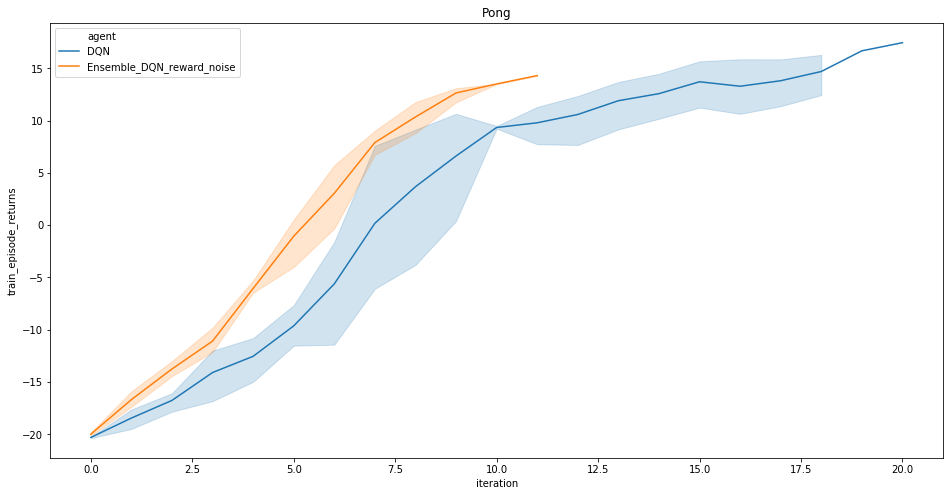

In [12]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data['Pong'], ax=ax)
plt.title('Pong')
plt.show()